In [1]:
# On importe les librairies usuelless
import math
import numpy as np
import matplotlib.pyplot as plt

# On désactive les warnings
import warnings
warnings.filterwarnings('ignore')

# On charge directement la base IMDB par les datasets de Keras
# La méthode load_date possède pas mal d'options et de propriétés intéressantes (voir description) :
# 1) Sépare les jeux d'entrainement et de test
# 2) num_words : Top most frequent words to consider.
# 3) skip_top : Top most frequent words to ignore (they will appear as oov_char value in the sequence data).
# 4) maxlen : Maximum sequence length. Any longer sequence will be truncated.
# 5) seed : Seed for reproducible data shuffling.
# 6) start_char : The start of a sequence will be marked with this character. Set to 1 because 0 is usually the padding character.
# 7) oov_char : words that were cut out because of the num_words or skip_top limit will be replaced with this character.
# 8) index_from : Index actual words with this index and higher.

from tensorflow.keras.datasets import imdb

num_words = 5000
max_len   =  100

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words,
                                                      maxlen=max_len)
            

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# On padde les séquences
print("La phrase avant padding est : \n {}". format(x_train[0]))

# On padde les séquence de mot
max_len       = 100
x_train       = pad_sequences(x_train, maxlen=max_len, truncating='post')
x_test        = pad_sequences(x_test, maxlen=max_len, truncating='post')

print("La phrase paddée sur une longueur {} est : \n {}". format(max_len, x_train[0]))   

La phrase avant padding est : 
 [1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 2, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]
La phrase paddée sur une longueur 100 est : 
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    1  778  128   74   12  630  163   15    4 1766    2 1051    2
   32   85  156   45   40  148  139  121  664  665   10   10 1361  173
    4  749    2   16 3804    8    4  226   65   12   43  127   24    2
   10   10]
2773


## 3. Déclaration du réseau

La tâche consiste à prédire la valence d'un texte à partir de son contenu.
Pour ce faire nous allons créer une architecture many-to-one 
avec les réseaux RNNs
Le problème consiste à implémenter et apprendre
des réseaux avec - par exemple - les configurations suivantes : 
On va comparer les configurations suivantes : 
- Simple RNN avec dropout (avec un taux de 25% en sortie du RNN)
- RNN-LSTM gauche-droite classique
- LSTM bi-directionnel et return_sequences = False
- Plusieurs couches au choix. On veillera en particulier 
  à la valeur des arguments return_sequences
  
Dans le rapport à faire directement dans le notebook, on prendra soin de :
- reporter les losses sur les ensembles d'entrainement et de validation
- mesurer l'accuracy sur l'ensemble de test
On commentera les résultats obtenus en comparant les configurations
Quelle est la configuration donnant la meilleure performance ? 
Pourquoi ?

Aide : une couche LSTM bi-directionnelle est obtenue en appliquant sur la même couche une couche LSTM et une couche Bidirectional

In [3]:
# On importe les librairies pour le RNN
from tensorflow.keras.layers import Dense , Input , SimpleRNN, LSTM , Embedding, Dropout
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
import time

from keras.models import Sequential
from keras.callbacks import History

# On importe les librairies pour l'évaluation
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

class BaseModel(object):
    def __init__(self,archiConfig, trainingConfig, x_train, y_train, x_test, y_test):
        
        self.archiConfig = archiConfig
        self.trainingConfig  = trainingConfig
        self.x_train = x_train
        self.y_train = y_train
        self.x_test  = x_test
        self.y_test  = y_test

        self.dl_model = Sequential()     # DL model
        self.train_time = 0              # Training time
        self.history = History()         # History object, holds training history.
        self.predictions = np.array([])  # Predicted class labels.

        self.define_model() # Construct the model.
        self.compile_model()# Configure the  model.
        self.fit_model()    # Train the model using testing dataset.
        self.predict()      # Predict the class labels of testing dataset.
        self.computeCM()    # Computes the confusion matrix
        self.computeAccuracy() # Computes the accuracy on the test set
        self.plotTrainingHistory() 
        
        return

In [13]:
from abc import ABC, abstractmethod

class RNN(BaseModel):

    def __init__(self,archiConfig, trainingConfig, x_train, y_train, x_test, y_test):
        super().__init__(archiConfig, trainingConfig, x_train, y_train, x_test, y_test)
        return
    
    def define_model(self):
        self.dl_model = self.define_Architechture()   
        self.dl_model.summary()
        return 
    
    @abstractmethod 
    def define_Architechture(self):
        pass
    

    def compile_model(self):
        self.dl_model.compile(  loss = self.trainingConfig["compile_loss"],
                                optimizer = self.trainingConfig["compile_optimizer"],
                                metrics = [self.trainingConfig["compile_metrics"]]
                             )

    def fit_model(self):

        start_time = time.time()
        self.history = self.dl_model.fit( x = x_train,
                                           y = y_train,
                                           batch_size = self.trainingConfig["batch_size"],
                                           epochs = self.trainingConfig["num_epochs"],
                                           verbose = self.trainingConfig["fit_verbose"],
                                           validation_split = self.trainingConfig["validation_split"]
                                        )

        end_time = time.time()
        self.train_time = end_time - start_time
        print( "The model took %0.3f seconds to train.\n"%self.train_time )
        return

    def predict(self):
        y_hat = self.dl_model.predict( x = x_test, verbose = self.trainingConfig["predict_verbose"])
        
        # On prédit sur les données de test
        # On tranforme les prédictions en labels
        i_pos = [i for i in range(len(y_hat)) if y_hat[i]>0]
        i_neg = [i for i in range(len(y_hat)) if y_hat[i]<=0]

        y_pred   = np.zeros(len(y_hat))
        y_pred[i_pos] = 1
        y_pred[i_neg] = 0
        
        self.predictions = y_pred
        return
    
    def computeCM(self):
        # On calcule la matrice de confusion
        cm_test = confusion_matrix(self.y_test, self.predictions)
        print('La matrice de confusion sur le jeu de test :\n', cm_test, '\n')
    
    def computeAccuracy(self):
        # On calcul le score d accuracy
        acc_train=accuracy_score(y_test, self.predictions)
        print('L accuracy sur le jeu de test est :\n', acc_train)
        
    def plotTrainingHistory(self):
        # On trace l'évolution de l'accuracy
        plt.figure(figsize= (6,2))
        plt.subplot(1,2,1)
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy']) 
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        #plt.show()
        # On trace l'évolution de la loss
        plt.subplot(1,2,2)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        #plt.show()

In [5]:
class mySimpleRNN(RNN):
    def __init__(self,archiConfig, trainingConfig, x_train, y_train, x_test, y_test):
        super().__init__(archiConfig, trainingConfig, x_train, y_train, x_test, y_test)
        return
    def define_Architechture(self):
        self.dl_model = Sequential()
        self.dl_model.add(Embedding(self.archiConfig["num_words"], self.archiConfig["mbed_size"]))          # layer embedding
        self.dl_model.add(SimpleRNN(self.archiConfig["RNN_size"], return_sequences = self.archiConfig["return_sequences"]))    # layer RNN
        self.dl_model.add(Dropout(self.archiConfig["dropout_percentage"]))                             # layer Dropout
        self.dl_model.add(Dense(1))         
        return self.dl_model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                5152      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 645,185
Trainable params: 645,185
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
35/35 [==============================] - 8s 92ms/step - loss: 2.4300 - accuracy: 0.4734 - val_loss: 0.7259 - val_accuracy: 0.5099
Epoch 2/10
35/35 [=====================

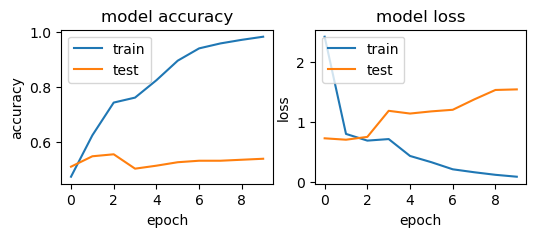

In [6]:
simpleRNN_archiConfig ={
    "num_words": 5000 ,
    "mbed_size": 128,
    "RNN_size": 32,
    "return_sequences": False,
    "dropout_percentage" : 0.25,
}
trainingConfig = {
    "compile_loss": 'binary_crossentropy',
    "compile_optimizer": 'adam',
    "compile_metrics": 'accuracy',

    "batch_size": 64,
    "num_epochs": 10,
    "fit_verbose": False,
    "validation_split": 0.2,
    
    "evaluate_verbose": True,
    "predict_verbose": True,  
}

# Construct, compile, train and evaluate the  Model.
simpleRNNmodel = mySimpleRNN(simpleRNN_archiConfig, trainingConfig, x_train, y_train, x_test, y_test) 

# Simple LSTM

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         640000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 771,713
Trainable params: 771,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
35/35 [==============================] - 15s 232ms/step - loss: 1.1783 - accuracy: 0.4793 - val_loss: 0.6591 - val_accuracy: 0.6396
Epoch 2/10
35/35 [===================

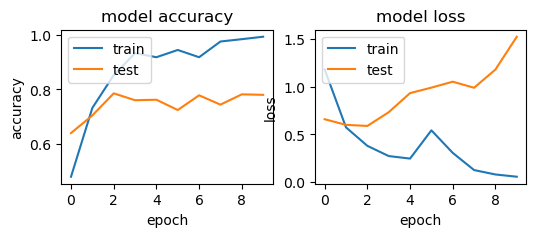

In [7]:
class mySimpleLSTM(RNN):
    def __init__(self,archiConfig, trainingConfig, x_train, y_train, x_test, y_test):
        super().__init__(archiConfig, trainingConfig, x_train, y_train, x_test, y_test)
        return
    def define_Architechture(self):
        self.dl_model = Sequential()
        self.dl_model.add(Embedding(self.archiConfig["num_words"], self.archiConfig["mbed_size"]))          
        self.dl_model.add(LSTM(self.archiConfig["LSTM_size"], 
                                    return_sequences = False,
                                    ))      #activation = self.archiConfig["LSTM_Activation"]            
        self.dl_model.add(Dropout(self.archiConfig["LSTM_dropout_percentage"]))                      
        self.dl_model.add(Dense(1))         
        return self.dl_model
    
simpleLSTM_archiConfig ={
    "num_words": 5000 ,
    "mbed_size": 128,
    "LSTM_size": 128,
    "LSTM_Activation" : 'relu',
    "LSTM_dropout_percentage" : 0.4
}

# Construct, compile, train and evaluate the  Model.
simpleLSTMmodel = mySimpleLSTM(simpleLSTM_archiConfig, trainingConfig, x_train, y_train, x_test, y_test) 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 738,945
Trainable params: 738,945
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
35/35 [==============================] - 43s 702ms/step - loss: 0.9705 - accuracy: 0.5347 - val_loss: 0

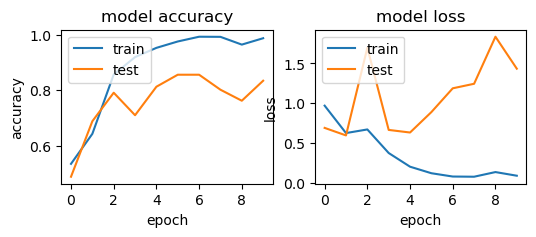

In [8]:
class myBI_LSTM(RNN):
    def __init__(self,archiConfig, trainingConfig, x_train, y_train, x_test, y_test):
        super().__init__(archiConfig, trainingConfig, x_train, y_train, x_test, y_test)
        return
    def define_Architechture(self):
        self.dl_model = Sequential()
        self.dl_model.add(Embedding(self.archiConfig["num_words"], self.archiConfig["mbed_size"]))          
        self.dl_model.add(Bidirectional(layer = LSTM(self.archiConfig["BI_LSTM_size"], 
                                                  return_sequences = False, 
                                                  dropout=0.2, 
                                                  recurrent_dropout=0.2),
                                       merge_mode="concat", weights=None, 
                                       backward_layer=None))  
        
        self.dl_model.add(Dropout(self.archiConfig["BI_LSTM_dropout_percentage"]))                                           
        self.dl_model.add(Dense(1)) 
        return self.dl_model
    
BI_LSTM_config ={
    "num_words": 5000 ,
    "mbed_size": 128,
    "BI_LSTM_size": 64,
    "BI_LSTM_dropout_percentage" : 0.4
}

# Construct, compile, train and evaluate the  Model.
BI_LSTMmodel = myBI_LSTM(BI_LSTM_config, trainingConfig, x_train, y_train, x_test, y_test) 

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 128)         640000    
                                                                 
 lstm_11 (LSTM)              (None, None, 128)         131584    
                                                                 
 dropout_12 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_12 (LSTM)              (None, None, 64)          49408     
                                                                 
 dropout_13 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_14 (Dropout)        (None, 32)              

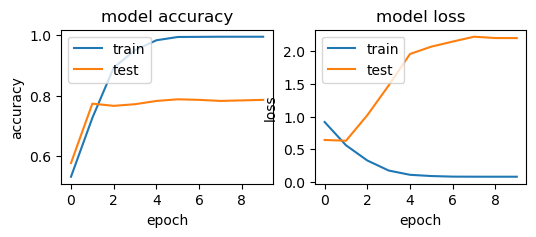

In [16]:
class myDeep_LSTM(RNN):
    def __init__(self,archiConfig, trainingConfig, x_train, y_train, x_test, y_test):
        super().__init__(archiConfig, trainingConfig, x_train, y_train, x_test, y_test)
        return
    def define_Architechture(self):
        self.dl_model = Sequential()
        self.dl_model.add(Embedding(self.archiConfig["num_words"], self.archiConfig["mbed_size"]))   
        self.dl_model.add(LSTM(self.archiConfig["LSTM_size_1"], return_sequences = True))          
        self.dl_model.add(Dropout(self.archiConfig["LSTM_dropout_percentage_1"])) 
        self.dl_model.add(LSTM(self.archiConfig["LSTM_size_2"], return_sequences = True))
        self.dl_model.add(Dropout(self.archiConfig["LSTM_dropout_percentage_2"]))  
        self.dl_model.add(LSTM(self.archiConfig["LSTM_size_3"], return_sequences = False))
        self.dl_model.add(Dropout(self.archiConfig["LSTM_dropout_percentage_3"]))  
        
        self.dl_model.add(Dense(1))                                               
        return self.dl_model
    
deep_LSTM_config ={
    "num_words": 5000 ,
    "mbed_size": 128,
    "LSTM_size_1": 128,
    "LSTM_dropout_percentage_1" : 0.25,
    
    "LSTM_size_2" : 64,
    "LSTM_dropout_percentage_2" : 0.25,
    
    "LSTM_size_3" : 32,
    "LSTM_dropout_percentage_3" : 0.25
}

trainingConfig["fit_verbose"] = False
# Construct, compile, train and evaluate the  Model.
deep_LSTMmodel = myDeep_LSTM(deep_LSTM_config, trainingConfig, x_train, y_train, x_test, y_test) 

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, None, 128)         640000    
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 dropout_22 (Dropout)        (None, None, 128)         0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)               

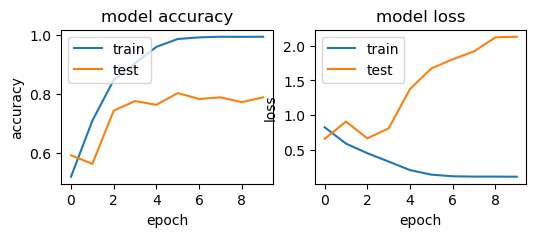

In [23]:
mbed_size = 128
class myDeep_BI_LSTM(RNN):
    def __init__(self,archiConfig, trainingConfig, x_train, y_train, x_test, y_test):
        super().__init__(archiConfig, trainingConfig, x_train, y_train, x_test, y_test)
        return
    def define_Architechture(self):
        self.dl_model = Sequential()
        self.dl_model.add(Embedding(self.archiConfig["num_words"], self.archiConfig["mbed_size"]))          
        self.dl_model.add(Bidirectional(layer = LSTM(64, return_sequences = True)))  
        self.dl_model.add(Dropout(0.25)) 
        self.dl_model.add(Bidirectional(layer = LSTM(32,return_sequences = False))) 
        self.dl_model.add(Dropout(0.25))
        self.dl_model.add(Dense(1)) 
        return self.dl_model

trainingConfig["fit_verbose"] = True
# Construct, compile, train and evaluate the  Model.
deep_BI_LSTMmodel = myDeep_BI_LSTM(deep_BI_LSTM_config, trainingConfig, x_train, y_train, x_test, y_test) 

Remarques : 

* Dans tout l'exercice, on utilise l'option return_sequences = False pour la derniere couche, car nous souhaitons indiquer l'humeur (positive ou négative) de la phrase à la fin de sa lecture

* Nous introduisant du droupout, pour aider le modèle à mieux se généraliser pour les données de test

* Les performances du Simple RNN ne sont pas satisfaisante, avec une accuracy de 0.5, très proche du hasard. Cela est peut etre du au vanishing du gradient.

* Nous remarquons que les couches LSTM sont mieux performantes de cet exercice, ceci du au fait de la longeur des séquences de phrases, et le phénomène du vanishing gradient.

* LSTM ignore les informations futures. Le LSTM bidirectionel contribue à l'entrainement du modèle en obtenant à la fois des informations historiques et des informations futures en utilisant le mécanisme de propagation bidirectionnelle, ce qui permet d'obtenir de meilleures performances dans l'analyse sentimentale. 

